# Giriş



**Amaç: Bu projede, haber metinlerini analiz ederek sahte (fake) veya gerçek (real) olup olmadığını sınıflandırmayı hedefliyoruz. Bu amaçla, metin verilerini işleyip, makine öğrenmesi modelleriyle sınıflandırma işlemi gerçekleştireceğiz.**


# Libraries


In [1]:
import pandas as pd
import numpy as np
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Veri Seti

Kullanılan Veri Seti: \
Fake News Detection Dataset

Özellikler:

Dengeli sınıf dağılımı: %50 fake, %50 real

Metin verileri içeriyor

In [2]:
df = pd.read_csv('/kaggle/input/fake-news-detection-dataset/fake_news_dataset.csv')  



# Veri Ön İşleme


In [3]:
def text_cleaning(text):
    text = text.lower()                            ## lowercase
    text = re.sub(r'\s+', ' ', text).strip()       ## additional sapces
    text = re.sub(r'https.\S+|www\S+', '',text)    ## remove links
    text = re.sub(r'@\w+', '', text)               ## remove mentions
    text = re.sub(r'#\w+','',text)                 ## remove hashtags
    text = re.sub(r'\s+([?.!,])', r'\1', text)     ## ## remove space before punctuation mark
    return text

In [4]:
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    tokens = [word for word in words if word not in stop_words]
    return ' '.join(tokens)

In [5]:
df['cleaned_text'] = df['text'].apply(text_cleaning)
df['label'] = df['label'].map({'real': 0, 'fake': 1})

In [6]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),         # 1-3 kelimelik kalıpları dahil et
    max_features=20000,         # daha fazla özellik
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label']


In [7]:
df['text'] = df['text'].apply(text_cleaning)
df['title'] = df['title'].apply(text_cleaning)

In [8]:
df['text'] = df['text'].apply(remove_stop_words)
df['title'] = df['title'].apply(remove_stop_words)

In [9]:
df['text'] = df['text'].dropna()
df['title'] = df['title'].dropna()

# Veri Görselleştirme


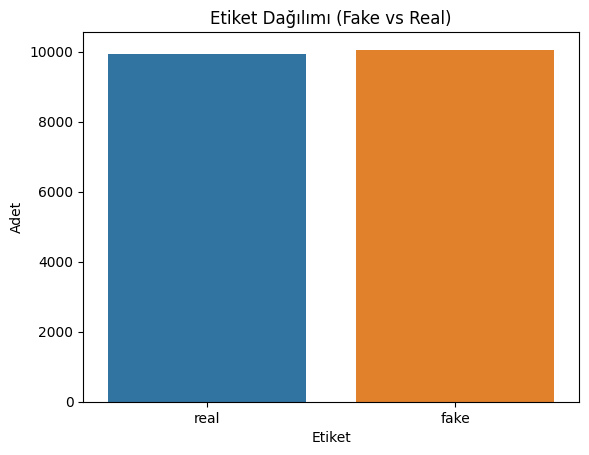

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['label'].map({0: 'real', 1: 'fake'}))
plt.title("Etiket Dağılımı (Fake vs Real)")
plt.xlabel("Etiket")
plt.ylabel("Adet")
plt.show()


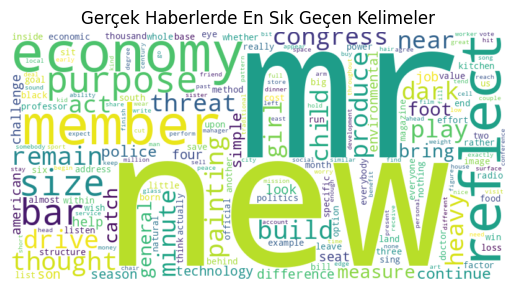

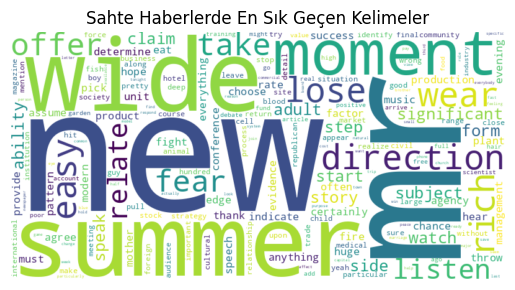

In [11]:
from wordcloud import WordCloud

text_real = " ".join(df[df['label'] == 0]['cleaned_text'])
text_fake = " ".join(df[df['label'] == 1]['cleaned_text'])

# Gerçek haberler
wc_real = WordCloud(width=800, height=400, background_color='white').generate(text_real)
plt.imshow(wc_real, interpolation='bilinear')
plt.axis('off')
plt.title("Gerçek Haberlerde En Sık Geçen Kelimeler")
plt.show()

# Sahte haberler
wc_fake = WordCloud(width=800, height=400, background_color='white').generate(text_fake)
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Sahte Haberlerde En Sık Geçen Kelimeler")
plt.show()


# Modelleme

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

**Model Eğitimi**

In [13]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

# Model Değerlendirme

In [14]:

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.51325
Precision: 0.5200783545543585
Recall: 0.523410547067521
F1 Score: 0.5217391304347827


**Confusion Matrix**

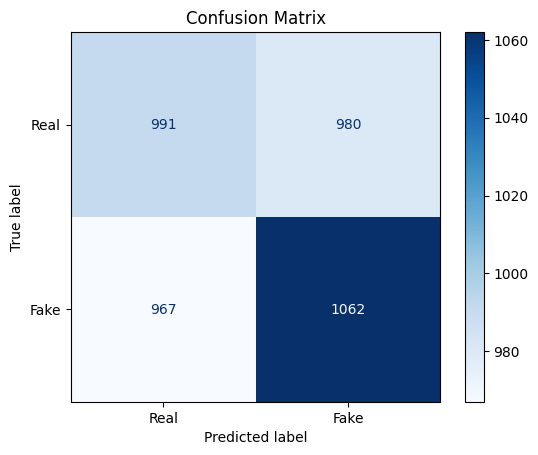

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


# Sonuçlar ve Değerlendirme

 **Bu projede metin verisi üzerinden sahte haber tespiti yapılmış, TF-IDF vektörizasyonu ile n-gram özellikleri çıkarılmış ve Logistic Regression modeli kullanılmıştır. Modelin performansı çeşitli metriklerle değerlendirilmiştir**

**Doğruluk (Accuracy)** \
Modelin genel doğruluğu %51.75’tir. Bu oran, sınıfların dengeli olması (%50 fake, %50 real) sebebiyle, modelin neredeyse rastgele tahmin ettiğini gösterir. Beklenenin aksine, daha gelişmiş özellik çıkarım yöntemleri veya modeller kullanmadan bu skorlar yeterli değildir.

**Precision (Kesinlik)** \
Modelin sahte haber (pozitif sınıf) tahmini yaptığında, bunun %52.4 oranında doğru olduğunu görüyoruz. Yani model bazı sahte haberleri yanlışlıkla gerçek haber olarak tahmin ediyor olabilir (false positives).

**Recall (Duyarlılık)** \
Modelin gerçek sahte haberleri doğru bir şekilde tespit etme oranı da yine %52.4’tür. Bu, modelin yaklaşık yarısını kaçırdığı anlamına gelir.

**F1 Skoru** \
Precision ve Recall’un harmonik ortalaması olan F1 skoru da %52.4’tür. Bu skor dengeli bir model için kritik bir göstergedir ve bu projede performansın artırılabileceğini açıkça ortaya koyar.

**Sonuçlar, metin sınıflandırmasının yüzeysel analizlerle sınırlı kalmaması gerektiğini ortaya koymaktadır. TF-IDF ve klasik makine öğrenmesi modelleri, dilin yüzeysel özelliklerini analiz edebilir; ancak haberin sahte olup olmadığını anlamak için bağlam, niyet, bilgi içeriği gibi daha derin yapısal unsurların da modele dahil edilmesi gerekir. Bu yüzden, bu proje bir temel oluşturmakla birlikte, daha gelişmiş doğal dil işleme tekniklerinin gerekliliğini de açıkça ortaya koymaktadır.**